<a href="https://colab.research.google.com/github/zrghassabi/Convolutional-Neural-Network/blob/main/Copy_of_Plate_classifier_with_testset_confusionmatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/manutrimble2022/sampleimages.git

Cloning into 'sampleimages'...
remote: Enumerating objects: 2214, done.
remote: Counting objects: 100% (2214/2214), done.
remote: Compressing objects: 100% (2202/2202), done.
remote: Total 2214 (delta 27), reused 2167 (delta 9), pack-reused 0
Receiving objects: 100% (2214/2214), 39.86 MiB | 11.76 MiB/s, done.
Resolving deltas: 100% (27/27), done.


# New Section

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir  = '//content//sampleimages//PlateClassification//'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
print('Number of training images:',dataset_sizes['train'])
print('Number of Validation images:',dataset_sizes['val'])
print('Number of Test images:',dataset_sizes['test'])
class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of training images: 1974
Number of Validation images: 161
Number of Test images: 67
['Class 1', 'Class 2', 'Class 3', 'Class 4']


{'test': Dataset ImageFolder
     Number of datapoints: 67
     Root location: //content//sampleimages//PlateClassification//test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'train': Dataset ImageFolder
     Number of datapoints: 1974
     Root location: //content//sampleimages//PlateClassification//train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFol

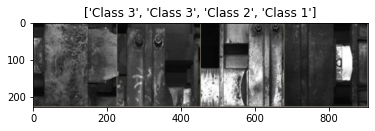

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = torchvision.models.resnet18(pretrained=True)
#model_ft = torchvision.models.alexnet(pretrained=True)
#model_ft = torchvisionmodels.googlenet(pretrained=True)

#model_ft = model_ft.eval()#fill in your model here 

# freezing all layers except final
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
#criterion = nn.L1Loss()
#criterion = nn.MSELoss()

#criterion = # fill in your loss function here 

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

#optimizer_ft = #fill in your optimizer here

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#define number of epochs here
number_of_epochs  =  25 #enter your epoch number here

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=number_of_epochs)

Epoch 0/24
----------
train Loss: 11.5298 Acc: 0.5431
val Loss: 7.5487 Acc: 0.7826

Epoch 1/24
----------
train Loss: 13.0289 Acc: 0.6206
val Loss: 7.4871 Acc: 0.8323

Epoch 2/24
----------
train Loss: 14.3784 Acc: 0.6687
val Loss: 7.9191 Acc: 0.7888

Epoch 3/24
----------
train Loss: 15.2415 Acc: 0.6657
val Loss: 7.1188 Acc: 0.8634

Epoch 4/24
----------
train Loss: 13.8968 Acc: 0.6824
val Loss: 3.6539 Acc: 0.9068

Epoch 5/24
----------
train Loss: 19.7095 Acc: 0.6575
val Loss: 10.9828 Acc: 0.8199

Epoch 6/24
----------
train Loss: 14.4179 Acc: 0.6991
val Loss: 5.1600 Acc: 0.8634

Epoch 7/24
----------
train Loss: 9.0667 Acc: 0.7553
val Loss: 2.8759 Acc: 0.9379

Epoch 8/24
----------
train Loss: 7.5770 Acc: 0.7756
val Loss: 2.9410 Acc: 0.9255

Epoch 9/24
----------
train Loss: 7.5121 Acc: 0.7730
val Loss: 1.7737 Acc: 0.9565

Epoch 10/24
----------
train Loss: 7.3136 Acc: 0.7771
val Loss: 1.7873 Acc: 0.9565

Epoch 11/24
----------
train Loss: 7.3272 Acc: 0.7639
val Loss: 2.0242 Acc: 0.

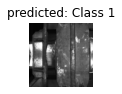

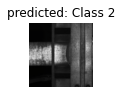

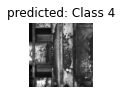

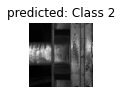

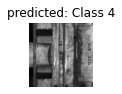

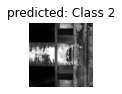

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [ ]:
nb_classes = 4

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[18.,  0.,  0.,  0.],
        [ 0., 17.,  0.,  1.],
        [ 0.,  0., 16.,  0.],
        [ 0.,  0.,  1., 14.]])


In [ ]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([1.0000, 0.9444, 1.0000, 0.9333])
